In [1]:
# modules

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.pardir)

from dataset.mnist import load_mnist
# 本書公式 GitHub (https://github.com/oreilly-japan/deep-learning-from-scratch) で提供されてるモジュール．
# カレントディレクトリに dataset をダウンロードして置いておく，
# あるいは普通にリモートリポジトリごと
# $ git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git
# でローカルに git clone しておく．

# from common.math_functions import *

%load_ext rpy2.ipython
# rpy2 で R も使いたい場合↑


In [2]:
# 4,5 章の勉強のときに作ったやつ．後で使うから定義しとく．


def numerical_gradient_batch(f, X):  # 複数の座標の勾配を計算する．
    grad = np.zeros_like(X) 
    for idx, x in enumerate(X):       # X の行をループ． 行番号が idx に入り，行ベクトルが x に入る．
        grad[idx, :] = numerical_gradient(f, x)
    return grad


def plot_grad_2d(f, x_range, y_range, sep, sign=1):
    
    x = np.arange(x_range[0], x_range[1], sep)  # x 軸の刻み
    y = np.arange(y_range[0], y_range[1], sep)  # y 軸の刻み

    X, Y = np.meshgrid(x, y)      # 全格子点の x 座標が X に， y 座標が Y に． [参考](https://deepage.net/features/numpy-meshgrid.html)
    # print(X, Y)                             # X , Y の [i , j] が　i 行 j　列の格子に対応
    # print(X.shape, Y.shape)

    X = X.flatten()                       # vec してベクトルに変換
    Y = Y.flatten()
    # print(X, Y)      # X,Yの対について勾配を求めて可視化すれば良い．
    # print(X.shape, Y.shape)
    
    grad = numerical_gradient_batch(f, np.array([X, Y]).T)
    # np.array([X, Y]) を .T で転置し， 行が case　で列が変数の形にし， 勾配計算関数に渡す

    plt.figure()  # 初期化的な．なくても良いかも．

    plt.quiver(X, Y, sign * grad[:, 0], sign * grad[:, 1],  angles="xy",color="#666666")
    # ベクトル場を plot する plt.quiver．
    # plt.quiver(x座標値, y座標値, ベクトルのx方向の値, ベクトルのy方向の値)
    # angles="xy" は x-y 平面に描画してねという指定．

    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid(linestyle=":")  # メモリの格子線を引く．
    plt.draw()  # 描画の実行的な．なくても良いかも．
    # plt.show()  # 表示的な．なくても良いかも．
    

def numerical_gradient(f, x):
    """数値的に勾配ベクトルを求める
    
    これまでに作った numerical_gradient() はベクトルを引数に取る関数だけが対象だった．
    ここでは，行列(重み係数W)を引数に取る関数(損失関数)の勾配も求められるようにする．
    Args:
      f: 勾配を求めたい関数．
      x: 勾配を求めたい地点 
    
    """
    h = 1e-4                            # 丸め誤差に注意し小さすぎない値
    grad = np.zeros_like(x)  #  勾配は変数と同じ形状．入力が行列な関数には勾配行列を求める．
    
    it = np.nditer(x, flags=['multi_index'])  # 勾配を求めたい座標値 x をイテレータ化．
    
    while not it.finished:           # イテレータなら ndim によらず1 重ループで書ける．
        
        idx = it.multi_index        # 元の行列 x の何行何列か
        tmp_val = x[idx]            # 変数 x_{idx} の元の値を逃しておく
        
        x[idx] = tmp_val + h     # 変数 x_{idx} を元の値からちょっとプラスにずらして，
        fxh1 = f(x)                     # その位置での関数値を取得．
        
        x[idx] = tmp_val - h      # 変数 x_{idx} を元の値からちょっとマイナスにずらして ，
        fxh2 = f(x)                     # その位置での関数値を取得．
        
        grad[idx] = (fxh1 - fxh2) / (2*h)    # 中心差分で偏微分係数を近似算出
        
        x[idx] = tmp_val            # 変数 x_{idx} の値を元に戻す．
        
        it.iternext()                    # イテレータを１つ進めて次の変数を見るようにする． 
        
    return grad

# 6章 学習に関するテクニック

この章でやるのは，学習の計算効率と汎化性能を上げるために選定する必要のある，

- 最適化手法 ( 更新アルゴリズム, optimizer )：6.1 節
- パラメータの初期値：6.2節
- 様々なメリットを持つ Batch Normalization：6.3 節
- over fitting を抑える正則化としての Weight decay と Dropout：6.4 節
- ハイパーパラメータチューニング ( Optuna 的な )：6.5 節

などなど．奥が深いだろうから MLP とか PRML とか Goodfellow 本も参照．


# 6.1. パラメータの更新

## 6.1.2. SGD

In [3]:
# SGD をクラスで実装


class SGD:
    """ (Stochastic) Gradient Descent optimizer
    
    クラスじゃなくて関数で実装しても良いと思うが，なんかアドバンテージあるんだろう．
    複数の optimizer のクラスに同じようなメソッドを持たせておけば，統一的に扱える，とかかな．
    → テキストの次ページに書いてあったので↓の md セルで引用した．
    
    Attributes:
      lr: learning rate
    
    """
    
    def __init__(self, lr=0.01):
        """ initialize
        
        Args:
          lr: learning rate.
        
        """
        self.lr = lr
        
    def update(self, params, grads):
        """ update params by Gradient Descent
        
        Args:
          params: パラメータ値の numpy.array を持った dictionary
          grads: 勾配の numpy.array を持った dictionary で， key は params に対応してる．
        
        Note:
          返却値は無し．その代わり，引数で渡したアドレスのとこのオブジェクトを上書きしてる．
        
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]
    

In [4]:
# ↑の SGD クラスの簡単な動作確認

optimizer = SGD(lr=0.1)
params = {
    "para1": np.random.normal(size=(2, 4)), 
    "para2": np.random.normal(size=(4))
}
grads = {
    "para1": np.random.normal(size=(2, 4)), 
    "para2": np.random.normal(size=(4))    
}
print(params["para1"])
print(params["para2"], "\n")
print(grads["para1"])
print(grads["para2"], "\n")
optimizer.update(params, grads)
print(params["para1"])
print(params["para2"])

# うんアルゴリズム通り計算できてる．

[[ 1.89311334 -1.35843595  0.54578159 -1.13479678]
 [-0.64250239  0.0959517  -0.69866095 -0.49144779]]
[-1.39573038  0.36578676 -0.5046904   0.96767144] 

[[-0.7667883  -1.48846111 -0.42417549  0.80794028]
 [ 0.20296839 -0.2374673  -1.55731683 -0.79150252]]
[-0.14979832 -1.23836849  0.80640203  1.25015287] 

[[ 1.96979217 -1.20958984  0.58819914 -1.21559081]
 [-0.66279922  0.11969843 -0.54292926 -0.41229754]]
[-1.38075054  0.48962361 -0.5853306   0.84265615]


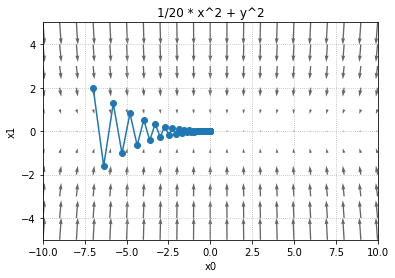

In [5]:
# 前に作った関数を使って図 6-3 的な描画をして， SGD クラスの動作確認

def func_tmp(x):
    return 1/20 * x[0]**2 + x[1]**2

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = SGD(lr=0.9)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

> [p168] このように、最適化を行うクラスを分離して実装することで、機能のモジュール化が容易になります。たとえば、この後すぐに Momentum という別の最適化手法を実装しますが、その Momentum も同じく `update(params, grads)` という共通のメ ソッドを持つように実装します。そうすれば、`optimizer = SGD()` という一文を、 `optimizer = Momentum()` に変更するだけでSGDをMomentumに切り替えるこ とができます。

ここが，SGD とかの optimizer を関数でなくクラスで実装するメリット．optimizer は必ず共通して「パラメータ更新」という操作をするが，他に各 optimizer 固有の操作が存在する時もあるだろう．こういうケースの時に，関数(イメージ的には単一のメソッド)で各 optimizer を実装するのは辛いし筋が悪い．必ず共通して .update() と言うメソッドを持つ (それ以外に各 optimizer 固有のメソッドを持ってていい) ようなクラスで実装する方が筋が良い．

また，あとで Momentum とか AdaGrad の実装の時に思ったが「過去の物体速度，勾配情報」みたいな「状態」を attributes に保持できるっていうのもクラスでの実装のメリット．

## 6.1.3. SGD の欠点

> [p169, 170] なお、SGD の非効率な探索経路の根本的な原因は、勾配の方向が本来の最小値ではない方向を指していることに起因します。この SGD の欠点を改善するため、続いて、SGD に代わる手法として、Momentum、 AdaGrad、Adam という 3 つ手法を紹介します。

この原因の説明は納得．図 6-1, 6-2, 6-3 もわかりやすい． Momentum, AdaGrad, Adam がどうやってこの原因を解決しているのかに注目していく．

## 6.1.4. Momentum

前までの速度を持っておいてるので「急に進む向きを変えたりしない，SGDみたいにジグザグに動かない」と言う感じか．

物理的にやってることはかなりシンプルで，１秒ごとに速度を「空気抵抗の力+勾配を降る方向の力を１秒間加え続けた時の速度」に変えて，１秒だけ進めている．「前の更新方向を記録しておいて，そこからあんまり急激に向きが変わらない」というのがポイント．

更新式のパラメータ $W$ を $x$ に代えて変形して，

$$
\begin{aligned}
v &\leftarrow \alpha v - \eta \frac{\partial L}{\partial x} \\
&= v + \left( - (1 - \alpha) v - \eta \frac{\partial L}{\partial x} \right) \\
x &\leftarrow x + v
\end{aligned}
$$

とすると物理的な解釈がしやすい．速度がベクトルであることに注意して，簡単なニュートン力学で考えると，

1. 物体が動いていない ( 速度 $v = 0$ ) シーンから始める． 
2. 空気抵抗の力と傾斜をくだる方向の力 (重力の傾斜方向の分力)の合力 $ - (1 - \alpha) v - \eta \frac{\partial L}{\partial x}$ を物体に１秒間かけ続けた時の速度 $v$ に更新する．( 質量は $m=1$ だと考える．つまり $F = ma = a$ と想定する．)
3. その速度で物体を等速直線運動させる．
4. 指定された回数だけ (もしくは収束つまり速度0になるまで) 2 と 3 を繰り返す．

と言う感じで解釈できる．

一定の力を加え続けて等加速度運動 (速度が連続的) をさせるわけではなく，離散的に速度を変化させ若干ジグザグな動きになるので,「球体をボウルに転がす」みたいなリアルな滑らかな物理運動にはならない．言い換えると，現実では物質が動くと刻一刻と受ける力 (勾配,空気抵抗) や速度も変化するが，そこまでは考慮してない．ただ，learning rate $\eta$ を小さめにしてステップ幅 (速度) を小さくすれば，ほぼリアルな動きになりそう．図 6-5 見るとそう思う．

DNN への Momentum の適用を論じた代表的な論文として，Sutskever et al. (2013) の [On the importance of initialization and momentum in deep learning](http://proceedings.mlr.press/v28/sutskever13.pdf) があって，そこでは

> The momentum method (Polyak, 1964), which we refer
to as classical momentum (CM), is a technique for accelerating gradient descent that accumulates a velocity vector in directions of persistent reduction in the objective across iterations. Given an objective function
$f(\theta)$ to be minimized, classical momentum is given by:
$$
v_{t+1} = \mu v_t - \varepsilon \Delta f(\theta_t) \\
\theta_{t+1} = \theta_t + v_{t+1}
$$
where $\varepsilon > 0$ is the learning rate, $\mu \in [0, 1]$ is the momentum coecient, and $\Delta f(\theta_t)$ is the gradient at $\theta_t$.

という風にアルゴリズムを定義してる．ここで $\mu \in [0, 1]$ は結構ポイントだと思って，なんでかというと，先ほど式変形して得た空気抵抗の係数が $(1-\alpha) > 0$ という感じで正の値になってくれるから．これでちゃんと「進行方向とは逆方向に空気抵抗の力がかかる」ことになってくれる．まあ結局，パラメータ $\alpha$ は「空気抵抗 (係数) の小ささ，勢いがどれくらい殺されないか」を表すことになる．

In [6]:
# Momentum をクラスで実装


class Momentum:
    """ Momentum optimizer
    
    Momentum を実装したクラス．
    イメージはボウルを転がる球体の運動．
    
    Attributes:
      lr: learning rate
      momentum: (1-momentum) が空気抵抗係数． 勢いがどのくらい殺されないか．
      v: 1秒(1更新)ごとに変化していく速度ベクトルの dict．
        key は .update() で初めて渡された params に対応するようになる．
        過去の運動の情報が速度の形で保存されていて，それが使われるのが Momentum の肝．
        こういう状態を保持できるのは，クラスで実装したメリットだなあ．
    
    """
    
    def __init__(self, lr=0.01, momentum=0.9):
        """ initialize
        
        Args:
          Attributes の docstring 参照．
        
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        """ update params by momentum method
        
        Args:
          params: パラメータ値の numpy.array を持った dictionary
          grads: 勾配の numpy.array を持った dictionary で， key は params に対応してる．
        
        """
        
        if self.v is None:  # 初めての更新の際は速度 v を 0 で初期化
            self.v = {}
            for key in params.keys():
                self.v[key] = np.zeros_like(params[key])
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


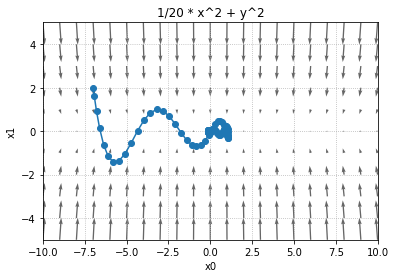

In [7]:
# 前に作った関数を使って図 6-5 的な描画をして， momentum クラスの動作確認

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = Momentum(lr=0.1, momentum=0.9)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

## 6.1.5. AdaGrad

> [p172, 173] 学習係数を徐々に下げていくというアイデアは、パラメータ「全体」の学習係数の 値を一括して下げることに相当します。これをさらに発展させたのが AdaGrad [6] です。AdaGrad は、「一つひとつ」のパラメータに対して、“オーダーメイド”の値をこしらえます。AdaGrad は、パラメータの要素ごとに適応的に学習係数を調整しながら学習を行う手法です(AdaGrad の Ada は「適応的」を意味する Adaptive に由来します)。

ここがポイント．大量にあるパラメータそれぞれに対して learning rate を別々に (適応的に) 定める．

行列は大文字で表したいし，アダマール積(要素ごとの積) を $\odot$ で表すのと同じように，アダマール除算は $\oslash$ で表し，要素単位の演算(べき乗) は $\circ$ をつける[そう](https://omedstu.jimdofree.com/2018/04/23/%E3%82%A2%E3%83%80%E3%83%9E%E3%83%BC%E3%83%AB%E6%BC%94%E7%AE%97%E5%AD%90-hadamard-operation/)なので， AdaGrad 更新式 (6.5), (6.6) は

$$
\begin{aligned}
H &\leftarrow
H+\frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}\\
W &\leftarrow
W - \eta \frac{\partial L}{\partial W} \oslash H^{\circ -\frac{1}{2}}
\end{aligned}
$$

と表しておこう．


> [p173] この $h$ は、式 (6.5) で示されるように、これまで経験した勾配の値を 2 乗和として
保持します(式 (6.5) の $\odot$ は行列の要素ごとの掛け算を意味します)。そして、パラ
メータの更新の際に、$\frac{1}{h}$ を乗算することで、学習のスケールを調整します。これは、パラメータの要素の中でよく動いた(大きく更新された)要素は、学習係数が小さく なることを意味します。つまり、よく動いたパラメータの学習係数は次第に小さくな るという学習係数の減衰を、パラメータの要素ごとに行うことができるのです。AdaGrad は、過去の勾配を 2 乗和としてすべて記録します。そのため、学習を進めれば進めるほど、更新度合いは小さくなります。

わかりやすい．確かにこれなら SGD のジグザグ反復運動にペナルティが課される感じになってうまくいきそう．実際，テキストでも

> [p174] 図 6-6 の結果を見ると、最小値に向かって効率的に動いているのが分かります。$y$ 軸方向へは勾配が大きいため、最初は大きく動きますが、その大きな動きに比例して、更新のステップが小さくなるように調整が行われます。そのため、$y$ 軸方向への 更新度合いは弱められていき、ジグザグの動きが軽減されます。

とコメントされているし．

> [p173] AdaGrad は、過去の勾配を 2 乗和としてすべて記録します。そのため、学習を進めれば進めるほど、更新度合いは小さくなります。そのため、学習 を進めれば進めるほど、更新度合いは小さくなります。実際のところ、無限に 学習を行ったとすると、更新量は 0 になり、まったく更新されません。この問 題を改善した手法として、RMSProp [7] という方法があります。RMSProp という手法は、過去のすべての勾配を均一に加算していくのではなく、過去の 勾配を徐々に忘れて、新しい勾配の情報が大きく反映されるように加算します。 専門的には「指数移動平均」と言って、指数関数的に過去の勾配のスケールを 減少させます。

なるほど．

In [8]:
# AdaGrad をクラスで実装


class AdaGrad:
    """ AdaGrad optimizer
    
    Attributes:
      lr: learning rate
      h: 過去の勾配の二乗和
    
    """
    
    def __init__(self, lr=0.01):
        """ initialize
        
        """
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        """ update params by AdaGrad
        
        """
        if self.h is None:
            self.h = {}
            for key in params.keys():
                self.h[key] = np.zeros_like(params[key])
                
        for key in params.keys():
            self.h[key] += grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  # 0除算対策

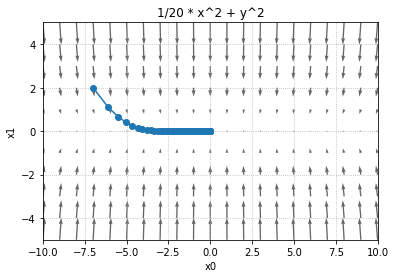

In [9]:
# 前に作った関数を使って図 6-6 的な描画をして， AdaGrad クラスの動作確認

def func_tmp(x):
    return 1/20 * x[0]**2 + x[1]**2

plot_grad_2d(func_tmp, [-10, 10.01], [-5, 5.01], 1.0, sign=-1)
# numerical_gradient_batch(function_2, np.array([[3.0, 4.0], [2.0, 3.0]]))

optimizer = AdaGrad(lr=0.9)
params = {"k": np.array([-7.0, 2.0])}
iters = 100
lis = np.zeros(shape=(iters, 2))
for i in range(iters):
    grads = {"k": numerical_gradient(func_tmp, params["k"])}
    lis[i, 0] = params["k"][0]
    lis[i, 1] = params["k"][1]    
    optimizer.update(params, grads)

plt.plot(lis[:, 0], lis[:, 1], marker="o")
plt.title("1/20 * x^2 + y^2")
plt.show()

今週

----

----

来週

## 6.1.6. Adam

まだ理解不足．参考資料だけ挙げといて，来週勉強．

- [Adam原論文](https://arxiv.org/pdf/1412.6980.pdf)
- [Goodfellow の optimizer の章](http://www.deeplearningbook.org/contents/optimization.html)
- [1](https://www.slideshare.net/MotokawaTetsuya/optimizer-93979393)：スライド13にAdamのアイディア．
- [2](https://www.slideshare.net/nishio/ss-66840545)：スライド25にAdamのアイディア．
- [An overview of gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/index.html#adam)：理論についてある程度しっかりかつわかりやすく書かれている．Adagrad + Momentum と言える理由とかも．バイス補正の話も少し．
- [原論文を読んでるブログ](https://qiita.com/exp/items/99145796a87cc6cd47e1)：理論がめッチャわかりやすい．確率的目的関数っての導入し，1次2次モーメントのバイアス補正の話へ．

## 6.1.8. MNIST データセットによる更新手法の比較

> 一般に SGD よりも他 の 3 つの手法のほうが速く学習でき、時には最終的な認識性能も高くなります。

実際この MNIST の実験では，結果の図 6-9 を見ると，SGD よりも他３つの方が訓練ロスを小さくできている，訓練ロス関数のより深いところにたどり着けている．（汎化性能はどうか分からないけど）

# 6.2. 重みの初期値